## Compile the redox potentials
We want to see what the energy differences for different methods are


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress
from ase.db import connect
import pandas as pd
import numpy as np

## Load the Database into Pandas
Get the energies for each system for each CP2K setting

In [2]:
example_molecules = pd.read_csv('../data/example_molecules.csv')

In [3]:
mol_props = example_molecules.set_index('inchi_key').to_dict('index')

In [4]:
data = []
for psolver in ['mt', 'wavelet']:
    with connect(f'{psolver}/data.db') as db:
        for row in db.select(''):
            record = row.key_value_pairs.copy()
            record['n_electrons'] = mol_props[record['inchi_key']]['n_electrons']
            record['energy'] = row.energy
            record['solver'] = psolver
            data.append(record)
data = pd.DataFrame(data)
print(f'Loaded {len(data)} computations')

Loaded 31 computations


## Compute the redox potentials
Get the energy differences between different stats

In [5]:
method_keys = ['solver', 'basis_set', 'xc', 'cutoff', 'buffer']
records = []
for lid, (level, subset) in enumerate(data.groupby(method_keys)):
    method_desc = dict(zip(method_keys, level))
    
    # Match states
    neutrals = subset.query('state=="neutral"')
    for state in ['oxidized', 'reduced']:
        redoxed = subset.query(f'state=="{state}"')
        merged = redoxed.merge(neutrals, on='inchi_key')
        
        # Create a record for each
        for _, row in merged.iterrows():
            record = {}
            record['inchi_key'] = row['inchi_key']
            record['state'] = state
            record['potential'] = row['energy_x'] - row['energy_y']
            record['runtime'] = row['runtime_x'] + row['runtime_y']
            record['level_id'] = lid
            record['n_electrons'] = row['n_electrons_x']
            record.update(method_desc)
            records.append(record)
records = pd.DataFrame(records)

In [6]:
records.groupby(['inchi_key', 'state', 'basis_set'])['potential'].describe()

count       mean       std  \
inchi_key                   state    basis_set                                  
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    1.0   8.743242       NaN   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    5.0   9.666196  0.002461   
                            reduced  AUG-DZVP-GTH    1.0   0.697093       NaN   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    1.0   9.104310       NaN   
                            reduced  AUG-DZVP-GTH    1.0   0.372106       NaN   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    5.0  12.255998  0.000074   
                            reduced  AUG-DZVP-GTH    5.0   0.795039  0.020956   

                                                         min        25%  \
inchi_key                   state    basis_set                            
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   8.743242   8.743242   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.663468   9.665306   
                            reduced  AUG-DZVP-GTH   0.697093   0.697093   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.104310   9.104310   
                            reduced  AUG-DZVP-GTH   0.372106   0.372106   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  12.255908  12.255978   
                            reduced  AUG-DZVP-GTH   0.781743   0.781748   

                                                         50%        75%  \
inchi_key                   state    basis_set                            
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   8.743242   8.743242   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.665407   9.666715   
                            reduced  AUG-DZVP-GTH   0.697093   0.697093   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.104310   9.104310   
                            reduced  AUG-DZVP-GTH   0.372106   0.372106   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  12.255982  12.256013   
                            reduced  AUG-DZVP-GTH   0.781791   0.800218   

                                                         max  
inchi_key                   state    basis_set                
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   8.743242  
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.670081  
                            reduced  AUG-DZVP-GTH   0.697093  
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   9.104310  
                            reduced  AUG-DZVP-GTH   0.372106  
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  12.256112  
                            reduced  AUG-DZVP-GTH   0.829692

In [7]:
records.groupby(['inchi_key', 'state', 'basis_set'])['runtime'].describe()

count         mean  \
inchi_key                   state    basis_set                          
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    1.0  2365.134006   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    5.0  2759.371927   
                            reduced  AUG-DZVP-GTH    1.0  1043.536140   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    1.0  3025.709570   
                            reduced  AUG-DZVP-GTH    1.0  1746.410090   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH    5.0   478.148490   
                            reduced  AUG-DZVP-GTH    5.0   283.062789   

                                                           std          min  \
inchi_key                   state    basis_set                                
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH          NaN  2365.134006   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  1280.604261  1131.556758   
                            reduced  AUG-DZVP-GTH          NaN  1043.536140   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH          NaN  3025.709570   
                            reduced  AUG-DZVP-GTH          NaN  1746.410090   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   221.306380   129.998320   
                            reduced  AUG-DZVP-GTH   141.616766    79.450116   

                                                           25%          50%  \
inchi_key                   state    basis_set                                
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  2365.134006  2365.134006   
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  2474.994872  2529.282334   
                            reduced  AUG-DZVP-GTH  1043.536140  1043.536140   
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  3025.709570  3025.709570   
                            reduced  AUG-DZVP-GTH  1746.410090  1746.410090   
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   416.584208   541.936407   
                            reduced  AUG-DZVP-GTH   226.171853   307.349038   

                                                           75%          max  
inchi_key                   state    basis_set                               
FPOLWERNILTNDK-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  2365.134006  2365.134006  
IJDNQMDRQITEOD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  2969.841690  4691.183981  
                            reduced  AUG-DZVP-GTH  1043.536140  1043.536140  
QLNJFJADRCOGBJ-UHFFFAOYSA-N oxidized AUG-DZVP-GTH  3025.709570  3025.709570  
                            reduced  AUG-DZVP-GTH  1746.410090  1746.410090  
VNWKTOKETHGBQD-UHFFFAOYSA-N oxidized AUG-DZVP-GTH   591.926154   710.297363  
                            reduced  AUG-DZVP-GTH   341.852874   460.490066

## Compare to NWChem
Make sure we are close to our baseline values

In [8]:
chosen_params = {'solver': 'mt', 'cutoff': 500}

In [9]:
chosen = records.copy()
for k, v in chosen_params.items():
    chosen = chosen[chosen[k] == v]
print(f'Reduced to {len(chosen)} results')

Reduced to 7 results


In [10]:
nwchem_results = pd.read_csv('../nwchem/nwchem-redox-potentials.csv')

Compare to NWChem

In [11]:
matched_basis = [('AUG-DZVP-GTH', 'aug-cc-pvdz')]

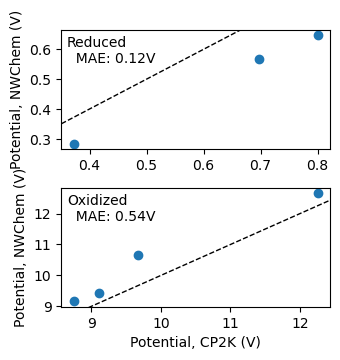

In [24]:
fig, axs = plt.subplots(2, len(matched_basis), figsize=(3.5, 3.5))

for ax, (cp2k_basis, nwc_basis) in zip(axs[:, None].T, matched_basis):
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_results.query(f'basis_set=="{nwc_basis}"'), on=('inchi_key', 'state'))
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = merged.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
    
        a.set_ylabel('Potential, NWChem (V)')
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, CP2K (V)')
    
fig.tight_layout()

Compare the runtimes

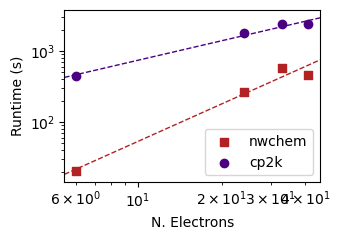

In [28]:
fig, axs = plt.subplots(1, len(matched_basis), sharey=True, figsize=(3.5, 2.5))

for ax, (cp2k_basis, nwc_basis) in zip([axs], matched_basis):
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_results.query(f'basis_set=="{nwc_basis}"'), on=('inchi_key', 'state'))
    
    subset = merged.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='nwchem')
    nwc_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='cp2k')
    cpk_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_ylabel('Runtime (s)')
    ax.set_xlabel('N. Electrons')
    
fig.tight_layout()